<a href="https://colab.research.google.com/github/BoWarburton/DS-Unit-1-Sprint-2-Statistics/blob/master/module2/LS_DS_122_Sampling_Confidence_Intervals_and_Hypothesis_Testing_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):


### Confidence Intervals:
1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

### Chi-squared tests:
4. Take a dataset that we have used in the past in class that has **categorical** variables. Pick two of those categorical variables and run a chi-squared tests on that data
  - By hand using Numpy
  - In a single line using Scipy


In [0]:
# Generate and numerically represent a confidence interval
# from congression voting records dataset
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data

--2020-01-21 22:32:18--  https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18171 (18K) [application/x-httpd-php]
Saving to: ‘house-votes-84.data’

house-votes-84.data 100%[===================>]  17.75K  --.-KB/s    in 0.06s   

2020-01-21 22:32:23 (288 KB/s) - ‘house-votes-84.data’ saved [18171/18171]



In [3]:
column_headers = ['party', 'handicapped-infants', 'water-project',
                  'budget', 'physician-fee-freeze', 'el-salvador-aid',
                  'religious-groups', 'anti-satellite-ban',
                  'aid-to-contras', 'mx-missile', 'immigration',
                  'synfuels', 'education', 'right-to-sue', 'crime', 'duty-free',
                  'south-africa']

df = pd.read_csv('house-votes-84.data',
                 header=None,
                 names=column_headers,
                 na_values='?')
df.head()

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,n,y,n,y,y,y,n,n,n,y,NaN,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,NaN
2,democrat,NaN,y,y,NaN,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,NaN,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,NaN,y,y,y,y


In [8]:
# Change 'y' to 1.0 and 'n' to 0
df = df.replace(['y', 'n'], [1.0, 0])
df.head()

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
2,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0


In [9]:
df_dem = df[df['party']=='democrat']
df_dem.head()

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
2,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0
5,democrat,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
6,democrat,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,1.0,1.0


In [10]:
df_rep = df[df['party']=='republican']
df_rep.head()

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
7,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,1.0
8,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
10,republican,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,1.0,0.0,0.0


In [0]:
def confidence_interval(data, confidence=0.95):
  """
  Calculate a confidence interval around a sample mean for given data.
  Using t-distribution and two-tailed test, default 95% confidence.
  Arguments:
    data - iterable (list or numpy array) of sample observations
    confidence - level of confidence for the interval  
  Returns:
    tuple of (mean, lower bound, upper bound)
  """
  mean = np.mean(data)
  data = np.array(data)
# data.values - works only if passing in pandas array
  n = len(data)
  s = np.std(data, ddof=1)
  stderr = s / np.sqrt(n)
  margin_of_error = stderr * stats.t.ppf((1 + confidence) / 2.0, n-1)
  return (mean, mean - stderr, mean + margin_of_error)

In [58]:
confidence_interval(df_dem['budget'].dropna())


(0.8884615384615384, 0.8689009570756285, 0.9269795615890052)

In [45]:
mean = np.mean(df_dem['budget'])
std = np.std(df_dem['budget'], ddof=1)
n = len(df_dem['budget'])
print('Mean:', mean)
print('Standard dev:', std)
print('Sample size:', n)

Mean: 0.8884615384615384
Standard dev: 0.3154048976795528
Sample size: 267


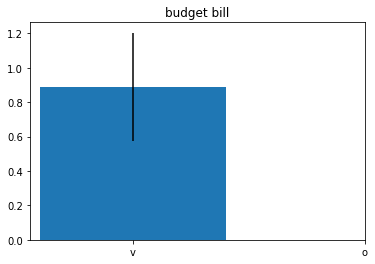

In [42]:
def graph_confidence_interval (height, margin_of_error, title_str='title', ticklabel_str='label'):
  #margin_of_error = 5
  fig, ax = plt.subplots()
  ax.bar(x=0, height=height, yerr=margin_of_error);
#ax.bar(x=1, height=20, yerr=7)
  ax.set_title(title_str)
  ax.set_xticks([0,1])
  ax.set_xticklabels(ticklabel_str)
#  ax.set_xticklabels(ticklabel_str['Budget Bill', 'Africa Bill'])
graph_confidence_interval(mean, std, 'budget bill', 'votes')

In [89]:
# load the mpg dataset
df = pd.read_csv('/content/mpg.csv')
df.head()

,Class,Manufacturer,carline name,displ,cyl,trans,drv,cty,hwy,cmb,ucty,uhwy,ucmb,fl,G,T,S,2pv,2lv,4pv,4lv,hpv,hlv,fcost,eng dscr,trans dscr
0,TWO SEATERS,ACURA,NSX,3.0,6,Auto(L4),R,18,24,20,19.7874,30.3000,23.4483,P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,975,DOHC-VTEC,2MODE CLKUP
1,TWO SEATERS,ACURA,NSX,3.2,6,Manual(M6),R,17,24,20,19.4000,30.1291,23.1020,P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,975,DOHC-VTEC,NaN
2,TWO SEATERS,BMW,M COUPE,3.2,6,Manual(M5),R,19,26,22,21.3353,33.7663,25.5717,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,785,NaN,NaN
3,TWO SEATERS,BMW,M ROADSTER,3.2,6,Manual(M5),R,19,26,22,21.3353,33.7663,25.5717,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,785,NaN,NaN
4,TWO SEATERS,BMW,Z3 COUPE,2.8,6,Auto(L4),R,19,26,22,20.9000,33.6000,25.1834,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,785,NaN,NaN


In [88]:
# make a crosstabs
contingency_table = np.array(pd.crosstab(df['Class'], df['trans']))
chi_2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)
print(chi_2_stat)

302.57325868621876


## Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.
3. Refactor your code so it is elegant, readable, and can be easily run for all issues.

## Resources

- [Interactive visualize the Chi-Squared test](https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html)
- [Calculation of Chi-Squared test statistic](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
- [Visualization of a confidence interval generated by R code](https://commons.wikimedia.org/wiki/File:Confidence-interval.svg)
- [Expected value of a squared standard normal](https://math.stackexchange.com/questions/264061/expected-value-calculation-for-squared-normal-distribution) (it's 1 - which is why the expected value of a Chi-Squared with $n$ degrees of freedom is $n$, as it's the sum of $n$ squared standard normals)